In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from load_images import load_images
import image_utils

In [2]:
image_matrix, label_array, img_size = load_images('YaleB')
image_matrix_0, mean_face, std = image_utils.img_normalize(image_matrix)

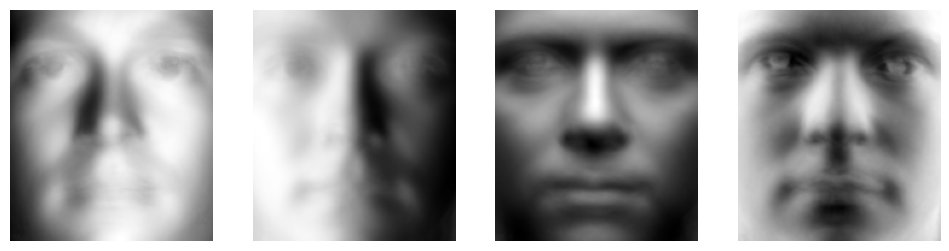

In [3]:
# Keep 95% of the variance
variance_percentage = 0.95

# Initialize PCA model
pca = PCA(n_components=variance_percentage)

# Fit PCA on the centered data
pca.fit(image_matrix_0)

# Transform the data into principal components
transformed_data = pca.transform(image_matrix_0)

# Visualize the first few eigenfaces
eigenfaces = pca.components_.reshape(-1, img_size[0], img_size[1])

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.axis('off')
plt.show()



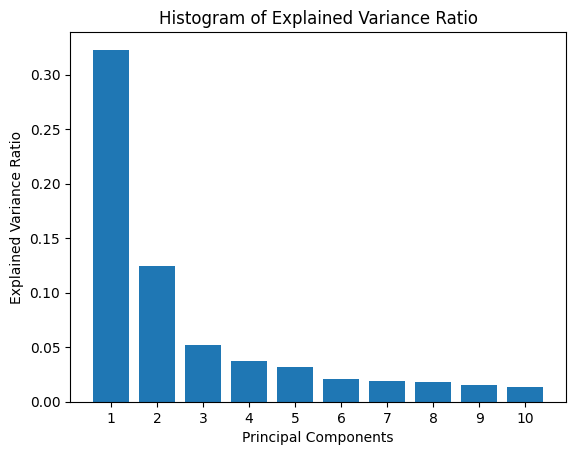

In [4]:
explained_variance = pca.explained_variance_ratio_[:20]
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Histogram of Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))  # Adding 1 to include all components in the axis
plt.show()

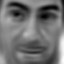

In [5]:
k = 200 # Image to be reconstructed


reconstructed_matrix = np.matmul(transformed_data, pca.components_)*std + mean_face

reconstructed_image = reconstructed_matrix[k,:].reshape(img_size)

# Apply min-max normalization to scale pixel values to 0-255 for display
min_val = np.min(reconstructed_image)
max_val = np.max(reconstructed_image)
reconstructed_image_normalized = 255 * (reconstructed_image - min_val) / (max_val - min_val)
reconstructed_image_normalized = Image.fromarray(np.uint8(reconstructed_image_normalized))

# Display the reconstructed image directly in the notebook
display(reconstructed_image_normalized)



In [10]:
# Unique classes in the dataset
unique_classes = np.unique(label_array)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = transformed_data[train_indices]
X_test = transformed_data[test_indices]
y_train = label_array[train_indices]
y_test = label_array[test_indices]

svm = SVC(kernel='linear', random_state=42, C=0.001)

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
    
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#
#print("Evaluation on Original Data with SVM:")
#evaluate_model(svm, X_train_pca, y_train, X_test_pca, y_test)

ValueError: With n_samples=1, test_size=None and train_size=0.9, the resulting train set will be empty. Adjust any of the aforementioned parameters.